In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score 
from collections import Counter 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score 
from sklearn.model_selection import KFold

## Import data 

Using these commands : 
- wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
- unzip bank+marketing.zip 
- unzip bank.zip 

After extracting, the data will be used is "bank-full.csv"

In [2]:
df = pd.read_csv('bank-full.csv', delimiter=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## Dataset Preparation

For the rest of the homework, you'll need to use only these columns:

'age',
'job',
'marital',
'education',
'balance',
'housing',
'contact',
'day',
'month',
'duration',
'campaign',
'pdays',
'previous',
'poutcome',
'y'

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [4]:
cols_ = [cols for cols in df.columns if cols not in ['default', 'loan']]
cols_

['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'contact',
 'day',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'y']

In [5]:
dfhw4 = df[cols_]

In [6]:
df_full_train, df_test = train_test_split(dfhw4, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.

Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [7]:
cols_q1 = ['balance', 'day', 'duration', 'previous'] 
auc_q1 = []

for cq1 in cols_q1:
    auc_col_q1 = roc_auc_score(y_train, df_train[cq1])
    if auc_col_q1 < 0.5:
        inverted_auc_q1 = roc_auc_score(y_train, -df_train[cq1])
        auc_q1.append(inverted_auc_q1)
    else:
        auc_q1.append(auc_col_q1)

df_q1 = pd.DataFrame({'variable' : cols_q1, 'auc_q1' : auc_q1}) 
df_q1.sort_values(by='auc_q1', ascending=False).reset_index(drop=True)

,variable,auc_q1
0,duration,0.814700
1,previous,0.598565
2,balance,0.588831
3,day,0.525958


The highest auc is with variable duration

## Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [14]:
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

# one hot encoding training dataset encoding using dictvectorizer 
dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

# train the model
modelq2 = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
modelq2.fit(X_train, y_train)

# one hot encoding validation dataset
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

# using validation dataset, predict the outcome
y_predq2 = modelq2.predict_proba(X_val)[:, 1]
aucq2 = roc_auc_score(y_val, y_predq2)
print('AUC on validation dataset : ', np.round(aucq2, 3))

AUC on validation dataset :  0.9


In [9]:
y_val

array(['no', 'no', 'no', ..., 'no', 'no', 'no'], dtype=object)

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them

In [10]:
actual_positive_q3 = (y_val == 'yes')
actual_negative_q3 = (y_val == 'no')

t_q3 = np.linspace(0.0, 1.0, int(1.0/0.01))
scores_q3 = []

for t in t_q3:
    predict_positive_q3 = (y_predq2 >= t)
    predict_negative_q3 = (y_predq2 < t)

    # true positive, true negative, false positive, false negative
    tp_q3 = (predict_positive_q3 & actual_positive_q3).sum()
    tn_q3 = (predict_negative_q3 & actual_negative_q3).sum()
    fp_q3 = (predict_positive_q3 & actual_negative_q3).sum()
    fn_q3 = (predict_negative_q3 & actual_positive_q3).sum()
    p_q3 = tp_q3 / (tp_q3 + fp_q3)
    r_q3 = tp_q3 / (tp_q3 + fn_q3) 

    scores_q3.append((t, p_q3, r_q3))

col_q3 = ['threshold', 'precision', 'recall']
df_q3 = pd.DataFrame(scores_q3, columns=col_q3)

/tmp/ipykernel_4111/2486048750.py:16: RuntimeWarning: invalid value encountered in scalar divide
  p_q3 = tp_q3 / (tp_q3 + fp_q3)


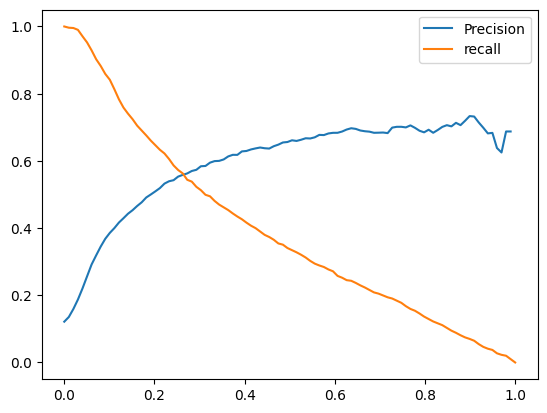

In [11]:
plt.plot(df_q3.threshold, df_q3.precision, label='Precision')
plt.plot(df_q3.threshold, df_q3.recall, label='recall')
plt.legend()
plt.show()

The intersect point is between 0.2 and 0.4. Based on the choice, the closest answer is 0.265

##  Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$ F1 = 2⋅\frac{P⋅R}{P+R} $$

Where 
- P is precision and 
- R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [13]:
df_q3['f1_score'] = 2*df_q3['precision']*df_q3['recall']/(df_q3['precision'] + df_q3['recall'])
df_q3[['threshold', 'f1_score']].sort_values(by='f1_score', ascending=False).reset_index(drop=True)

,threshold,f1_score
0,0.222222,0.573709
1,0.232323,0.570571
2,0.212121,0.570373
3,0.202020,0.569823
4,0.191919,0.569074
...,...,...
95,0.959596,0.052402
96,0.969697,0.043937
97,0.979798,0.038938
98,0.989899,0.019749


## Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

Iterate over different folds of df_full_train

Split the data into train and validation

Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

Use AUC to evaluate the model on validation

In [23]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores_q5 = []

for train_idx_q5, val_idx_q5 in kfold.split(df_full_train):
    df_train_q5 = df_full_train.iloc[train_idx_q5]
    df_val_q5 = df_full_train.iloc[val_idx_q5]

    y_train_q5 = df_train_q5.y.values
    y_val_q5 = df_val_q5.y.values

    dv_q5, model_q5 = train(df_train_q5, y_train_q5, C=1.0)
    y_pred_q5 = predict(df_val_q5, dv_q5, model_q5)

    auc_q5 = roc_auc_score(y_val_q5, y_pred_q5)
    scores_q5.append(auc_q5)

print("AUC result for folds : ", scores_q5)
print("Standard defintion of the scores across different folds : ", np.std(scores_q5))

AUC result for folds :  [np.float64(0.8992842405563055), np.float64(0.8990110164487815), np.float64(0.9111641244449282), np.float64(0.9078905031338849), np.float64(0.9119728949040351)]
Standard defintion of the scores across different folds :  0.005652844370349586


The closest value in the choices is 0.006

## Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]

Initialize KFold with the same parameters as previously

Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)

Compute the mean score as well as the std (round the mean and std to 3 decimal digits)